In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import os

## Messung

Die Funktion `trigger_signal` trimmt ein Audiosignal basierend auf einem Schwellenwert, indem sie den Abschnitt des Signals extrahiert, der den Schwellenwert überschreitet und wieder darunter fällt.

In [55]:
def trigger_signal(signal, threshold, rate):
    start_index = None
    for i, value in enumerate(signal):
        if abs(value) > threshold:
            start_index = i
            break

    if start_index is None:
        return np.array([], dtype=np.int16)

    end_index = len(signal)
    for i in range(start_index, len(signal)):
        if abs(signal[i]) <= threshold and all(abs(signal[i:i+int(rate*0.1)]) <= threshold):
            end_index = i
            break

    trimmed_signal = signal[start_index:end_index]

    return trimmed_signal

### Aufnahme

In [80]:
def record(FILENAME):
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = 1
    THRESHOLD = 550

    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=1024)

    print("Aufnahme startet...")
    frames = []
    for _ in range(0, int(RATE / 1024 * RECORD_SECONDS)):
        data = stream.read(1024)
        frames.append(np.frombuffer(data, dtype=np.int16))

    print("Aufnahme beendet.")
    stream.stop_stream()
    stream.close()
    p.terminate()

    signal = np.concatenate(frames)
    triggered_signal = trigger_signal(signal, THRESHOLD, RATE)
    np.save(FILENAME, triggered_signal)
    print(f"Signal gespeichert als {FILENAME}")

In [57]:
def plot_signal(FILENAME):
    signal = np.load(FILENAME)
    plt.figure(figsize=(20, 4))
    plt.plot(signal)
    plt.title('Audio-Signal')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

#### Test Aufnahme

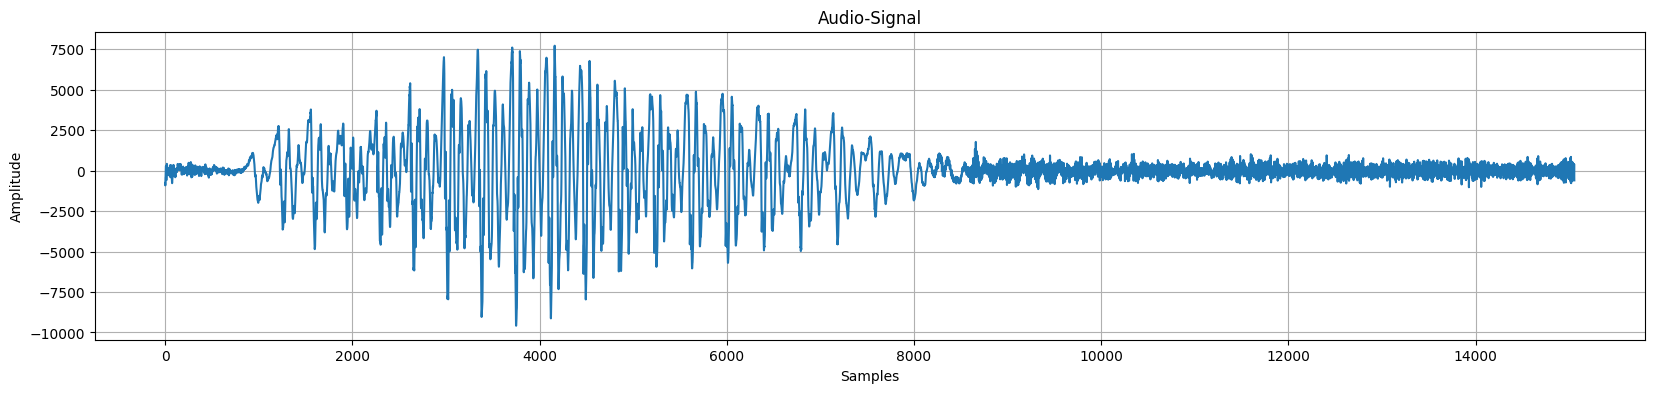

In [ ]:
name = 'test.npy'
record(name)
plot_signal(name)

In [121]:
def fourier_transform(FILENAME):
    signal = np.load(FILENAME)

    fft = np.fft.fft(signal)
    amplitude = np.abs(fft) / len(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/44100)

    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_amplitudes = amplitude[:len(amplitude)//2]

    return positive_frequencies, positive_amplitudes

fourier_transform('test.npy')

(array([0.00000000e+00, 2.35728031e+00, 4.71456062e+00, ...,
        2.20429282e+04, 2.20452854e+04, 2.20476427e+04]),
 array([0.14560616, 0.29695157, 0.2118524 , ..., 0.00989733, 0.00504351,
        0.001908  ]))

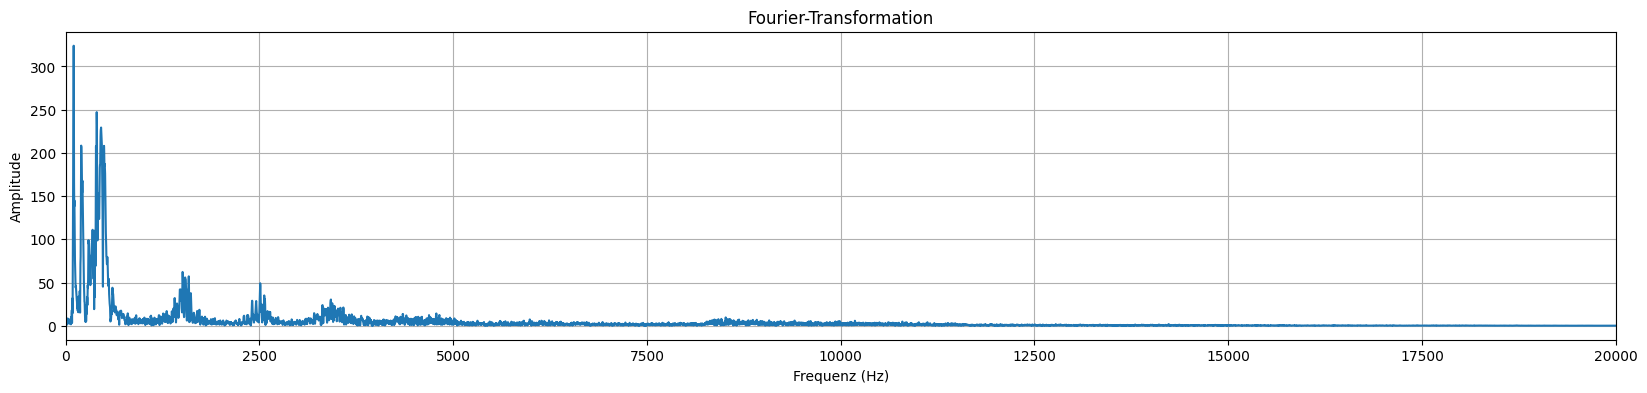

In [122]:
def plot_fourier_transform(FILENAME):
    frequencies, amplitudes = fourier_transform(FILENAME)

    plt.figure(figsize=(20, 4))
    plt.plot(frequencies, amplitudes)
    plt.title('Fourier-Transformation')
    plt.xlabel("Frequenz (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 20000)
    plt.grid()
    plt.show()

plot_fourier_transform('test.npy')

In [61]:
def gaussian_window(length, std_dev):
    n = np.arange(0, length) - (length - 1) / 2
    window = np.exp(-0.5 * (n / std_dev) ** 2)
    return window

gaussian_window(10, 10)

array([0.90370708, 0.94058806, 0.96923323, 0.98881304, 0.99875078,
       0.99875078, 0.98881304, 0.96923323, 0.94058806, 0.90370708])

In [62]:
def windowed_fourier_transform(signal, window_length=512):
    std_dev = window_length / 4
    guassian = gaussian_window(window_length, std_dev)

    # Fenster erstellen
    overlap = window_length // 2
    step = window_length - overlap
    windows = [
        signal[i:i + window_length]
        for i in range(0, len(signal) - window_length, step)
    ]

    # Fouriertransformation für jedes Fenster
    spectrum = []
    for window in windows:
        weighted_window = window * guassian
        fft = np.fft.fft(weighted_window, n=window_length)
        spectrum.append(np.abs(fft[:window_length//2])) # Nur positive Frequenzen

    average_spectrum = np.mean(spectrum, axis=0)
    frequencies = np.fft.fftfreq(window_length, 1/44100)[:window_length//2]

    return frequencies, average_spectrum

In [125]:
def plot_spectrum(frequencies, spectrum):
    plt.figure(figsize=(20, 4))
    plt.plot(frequencies, spectrum)
    plt.title('Spektrum')
    plt.xlabel("Frequenz (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 20000)
    plt.grid()
    plt.show()

### Gaußsche Fensterfunktion:
- Wird mit einer Länge von 512 erstellt.
- Die Fensterbreite entspricht `4 * 𝜎`, wobei `𝜎` die Standardabweichung ist.
- Das Signal wird in Fenster der Länge 512 aufgeteilt, mit 256 Samples Überlappung.
- Jedes Fenster wird mit der Gaußschen Fensterfunktion gewichtet.
- Die Fouriertransformation wird für jedes Fenster durchgeführt.

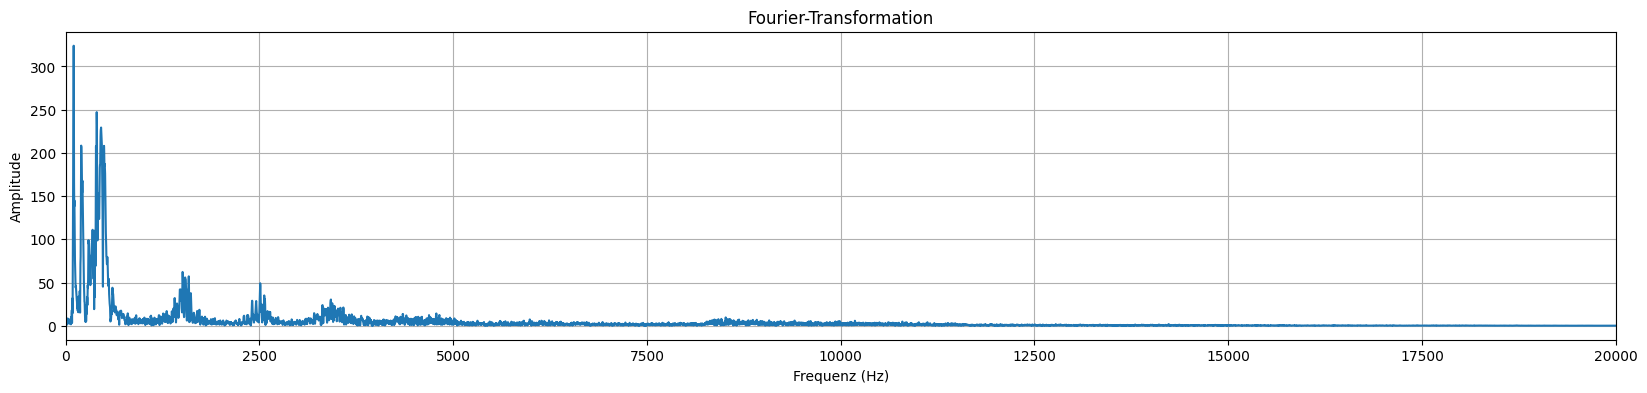

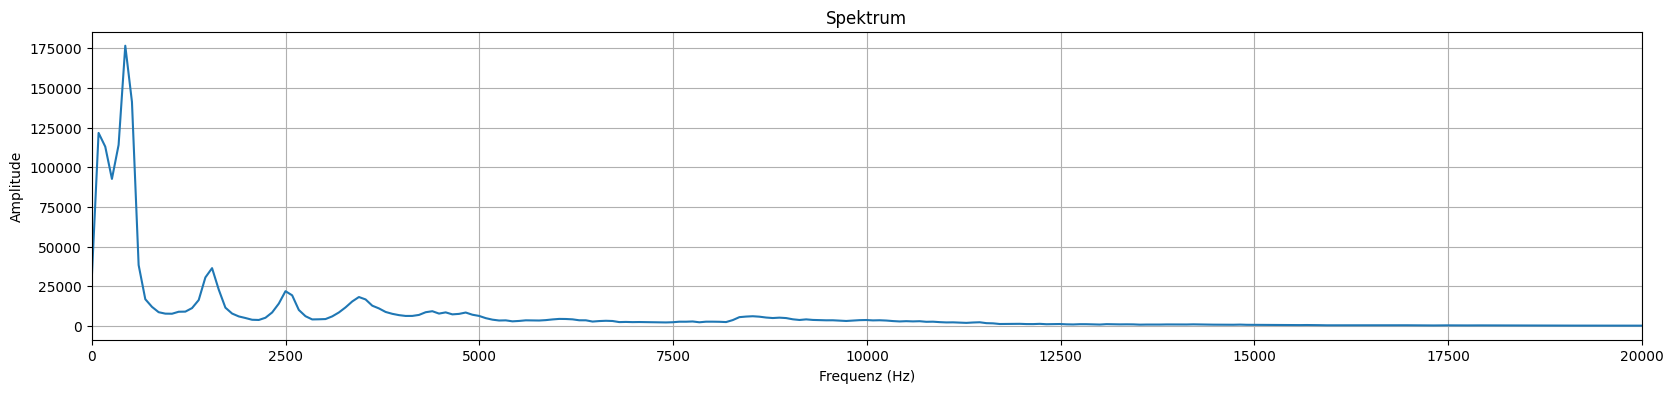

In [126]:
signal = np.load('test.npy')
frequencies, spectrum = windowed_fourier_transform(signal, window_length=512)
plot_fourier_transform('test.npy')
plot_spectrum(frequencies, spectrum)

# Aufgabe 2

### Funktion zum Laden von Dateien

In [65]:
def load_signals(folder, command):
    files = sorted([f for f in os.listdir(folder) if command in f])
    signals = [np.load(os.path.join(folder, f)) for f in files]
    return signals

load_signals('training', 'rechts')

[array([-53, -52, -47, ...,   7,  47,  56], dtype=int16),
 array([-51, -52, -54, ..., -25,  25,  51], dtype=int16),
 array([52, 56, 57, ..., 44, 50, 51], dtype=int16),
 array([-53, -54, -55, ...,  21, -27, -59], dtype=int16),
 array([-52, -51, -54, ...,   6,  44,  53], dtype=int16)]

### Funktion zur Mittelung von Spektren

In [66]:
def average_spectrum(signals, window_length=512):
    all_spectra = []
    for signal in signals:
        frequencies, spectrum = windowed_fourier_transform(signal, window_length)
        all_spectra.append(spectrum)
    average_spectrum = np.mean(all_spectra, axis=0)
    return frequencies, average_spectrum

signals = load_signals('training', 'rechts')
average_spectrum(signals)

(array([    0.       ,    86.1328125,   172.265625 ,   258.3984375,
          344.53125  ,   430.6640625,   516.796875 ,   602.9296875,
          689.0625   ,   775.1953125,   861.328125 ,   947.4609375,
         1033.59375  ,  1119.7265625,  1205.859375 ,  1291.9921875,
         1378.125    ,  1464.2578125,  1550.390625 ,  1636.5234375,
         1722.65625  ,  1808.7890625,  1894.921875 ,  1981.0546875,
         2067.1875   ,  2153.3203125,  2239.453125 ,  2325.5859375,
         2411.71875  ,  2497.8515625,  2583.984375 ,  2670.1171875,
         2756.25     ,  2842.3828125,  2928.515625 ,  3014.6484375,
         3100.78125  ,  3186.9140625,  3273.046875 ,  3359.1796875,
         3445.3125   ,  3531.4453125,  3617.578125 ,  3703.7109375,
         3789.84375  ,  3875.9765625,  3962.109375 ,  4048.2421875,
         4134.375    ,  4220.5078125,  4306.640625 ,  4392.7734375,
         4478.90625  ,  4565.0390625,  4651.171875 ,  4737.3046875,
         4823.4375   ,  4909.5703125,  4995.7031

In [129]:
def plot_reference_spectra(folder, commands):
    plt.figure(figsize=(20, 4))
    for command in commands:
        signals = load_signals(folder, command)
        frequencies, spectrum = average_spectrum(signals)
        plt.plot(frequencies, spectrum, label=command)
    plt.title('Referenz-Spektren')
    plt.xlabel("Frequenz (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 5000)
    plt.legend()
    plt.grid()
    plt.show()

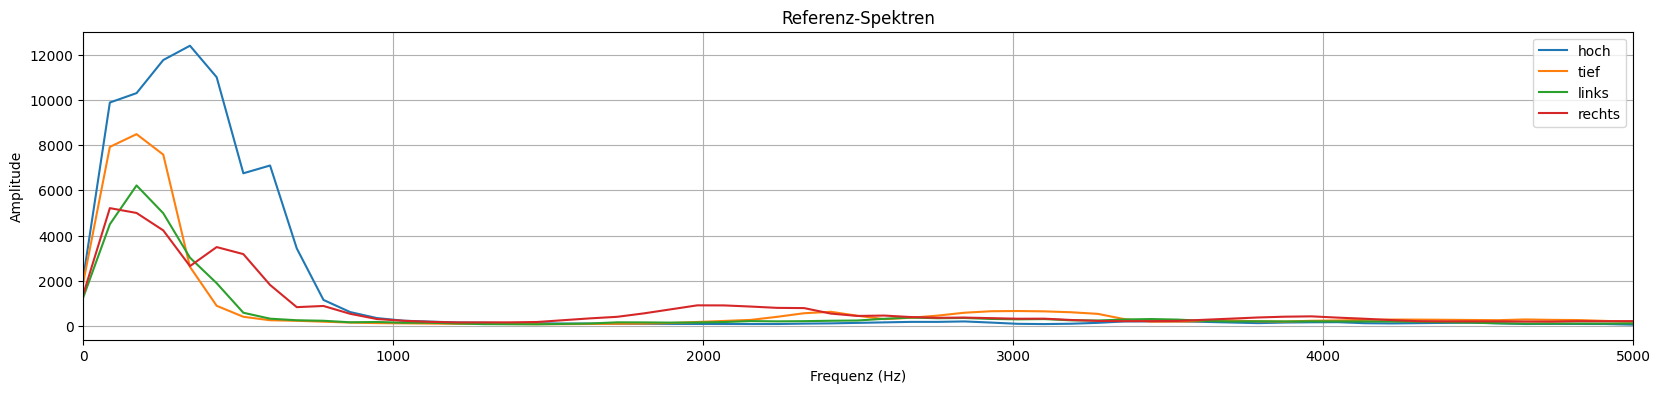

In [130]:
training_folder = 'training'
commands = ['hoch', 'tief', 'links', 'rechts']

plot_reference_spectra(training_folder, commands)

### Test der Routine mit Referenzspektren

In [69]:
def load_dataset(folder):
    commands = ["hoch", "tief", "links", "rechts"]
    dataset = {command: load_signals(folder, command) for command in commands}
    return dataset

Formel des Bravais-Pearson-Korrelationskoeffizienten: $
r = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}}
$

In [70]:
def bravais_correlation(spectrum1, spectrum2):
    mean1 = np.mean(spectrum1)
    mean2 = np.mean(spectrum2)

    numerator = np.sum((spectrum1 - mean1) * (spectrum2 - mean2))
    denominator = np.sqrt(np.sum((spectrum1 - mean1)**2) * np.sum((spectrum2 - mean2)**2))

    return numerator / denominator if denominator != 0 else 0

bravais_correlation([1, 2, 3], [1, 2, 3])

np.float64(1.0)

In [71]:
def compute_reference_spectra(training_data):
    references = {}
    for command, signals in training_data.items():
        references[command] = average_spectrum(signals)
    return references

compute_reference_spectra({'rechts': signals})

{'rechts': (array([    0.       ,    86.1328125,   172.265625 ,   258.3984375,
           344.53125  ,   430.6640625,   516.796875 ,   602.9296875,
           689.0625   ,   775.1953125,   861.328125 ,   947.4609375,
          1033.59375  ,  1119.7265625,  1205.859375 ,  1291.9921875,
          1378.125    ,  1464.2578125,  1550.390625 ,  1636.5234375,
          1722.65625  ,  1808.7890625,  1894.921875 ,  1981.0546875,
          2067.1875   ,  2153.3203125,  2239.453125 ,  2325.5859375,
          2411.71875  ,  2497.8515625,  2583.984375 ,  2670.1171875,
          2756.25     ,  2842.3828125,  2928.515625 ,  3014.6484375,
          3100.78125  ,  3186.9140625,  3273.046875 ,  3359.1796875,
          3445.3125   ,  3531.4453125,  3617.578125 ,  3703.7109375,
          3789.84375  ,  3875.9765625,  3962.109375 ,  4048.2421875,
          4134.375    ,  4220.5078125,  4306.640625 ,  4392.7734375,
          4478.90625  ,  4565.0390625,  4651.171875 ,  4737.3046875,
          4823.4375   , 

In [72]:
def recognize_speech(test_data, references):
    results = []
    for true_command, signals in test_data.items():
        for signal in signals:
            _, spectrum = windowed_fourier_transform(signal)
            spectrum = spectrum / np.linalg.norm(spectrum)
            correlations = {cmd: bravais_correlation(spectrum, ref[1]) for cmd, ref in references.items()}
            predicted_command = max(correlations, key=correlations.get)

            print(f"\033[92mErwartet: {true_command}\033[0m, \033[91mGegeben: {predicted_command}\033[0m, Correlations: { {cmd: f'{corr:.2f}' for cmd, corr in correlations.items()} }")

            results.append((true_command, predicted_command))
    return results

In [73]:
def evaluate_results(results):
    correct = sum(1 for true, pred in results if true == pred)
    total = len(results)
    detection_rate = correct / total * 100
    error_rate = (total - correct) / total * 100
    return detection_rate, error_rate

In [74]:
def train_and_test(training_folder, test_folder):
    training_data = load_dataset(training_folder)
    test_data = load_dataset(test_folder)

    references = compute_reference_spectra(training_data)
    results = recognize_speech(test_data, references)
    detection_rate, error_rate = evaluate_results(results)

    return detection_rate, error_rate

In [75]:
detection_rate, error_rate = train_and_test('training', 'test-marcel')
print(f"Detektionsrate: {detection_rate:.2f} %\nFehlerrate: {error_rate:.2f} %")

Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.99', 'tief': '0.74', 'links': '0.83', 'rechts': '0.92'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '1.00', 'tief': '0.76', 'links': '0.86', 'rechts': '0.92'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.99', 'tief': '0.82', 'links': '0.90', 'rechts': '0.94'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '1.00', 'tief': '0.76', 'links': '0.86', 'rechts': '0.91'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.99', 'tief': '0.80', 'links': '0.89', 'rechts': '0.94'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '1.00', 'links': '0.98', 'rechts': '0.88'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '0.99', 'links': '0.97', 'rechts': '0.88'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '0.99', 'links': '0.97', 'rechts': '0.88'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.81', 'tief': '0.99', 'links': '0.98', '

In [76]:
detection_rate, error_rate = train_and_test('training', 'test-mohammed')
print(f"Detektionsrate: {detection_rate:.2f} %\nFehlerrate: {error_rate:.2f} %")

Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.75', 'links': '0.83', 'rechts': '0.91'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.99', 'tief': '0.74', 'links': '0.83', 'rechts': '0.91'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.72', 'links': '0.81', 'rechts': '0.91'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.97', 'tief': '0.69', 'links': '0.78', 'rechts': '0.91'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.68', 'links': '0.78', 'rechts': '0.89'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '0.99', 'links': '0.97', 'rechts': '0.87'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.78', 'tief': '0.99', 'links': '0.96', 'rechts': '0.86'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '0.99', 'links': '0.97', 'rechts': '0.87'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.81', 'tief': '0.99', 'links': '0.97', '

In [77]:
detection_rate, error_rate = train_and_test('test-marcel', 'test-mohammed')
print(f"Detektionsrate: {detection_rate:.2f} %\nFehlerrate: {error_rate:.2f} %")

Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.78', 'links': '0.87', 'rechts': '0.89'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.99', 'tief': '0.78', 'links': '0.87', 'rechts': '0.89'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.75', 'links': '0.85', 'rechts': '0.89'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.72', 'links': '0.83', 'rechts': '0.88'}
Erwartet: hoch, Gegeben: hoch, Correlations: {'hoch': '0.98', 'tief': '0.71', 'links': '0.83', 'rechts': '0.86'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '0.98', 'links': '0.95', 'rechts': '0.89'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.78', 'tief': '0.98', 'links': '0.94', 'rechts': '0.89'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.80', 'tief': '0.99', 'links': '0.95', 'rechts': '0.90'}
Erwartet: tief, Gegeben: tief, Correlations: {'hoch': '0.81', 'tief': '0.98', 'links': '0.95', '